# **Data Cleaning:**
Summarize what we did in Excel, and some stuff moving into python
- dawg i had to manually remove values because 1). the list is so small, 2). not that hard as a result 3). excel/python would take more time
- deleted non 2021-2022 columns 

In [68]:
# further data cleaning in pandas
import pandas as pd
pd.options.mode.chained_assignment = None 

# read datasets
table6 = pd.read_csv("Matthew's Data/Table6.csv")
table8 = pd.read_csv("Matthew's Data/Table8.csv")
table9 = pd.read_csv("Matthew's Data/table9.csv")

# create list of all strings that contain the names of communities in table 8
community_names = table8["Community"].unique().tolist()

# filter the csv based on if it exists in the observed commmunities
table9_byAreaNames = table9[table9["Area Name"].isin(community_names)]

# IMPUTATION WARNING: the only value  
table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"] = table9_byAreaNames.loc[table9_byAreaNames["Area Name"] == "Grande Cache"].replace("--", "3276")

# convert 2022 column to integer values (since it is currently being read as string)
table9_byAreaNames["2022"] = table9_byAreaNames["2022"].apply(lambda x: int(x))

# display populations (alphabetical order)
table9_byAreaNames.drop(["2021"],axis=1,inplace=True) # remove 2021 column
table9_byAreaNames = table9_byAreaNames.sort_values("Area Name")
table9_byAreaNames

# clean again 
#print(len(community_names))
#print(len(table9_remove0.index))
#for i in community_names:
    #if not table9_filtered["Area Name"].str.contains(i).any():
        #print(i, "is not in here")
        

,Area Name,Type,2022
308,Athabasca,T,2827
330,Banff,T,9347
296,Barrhead,T,4503
26,Bassano,T,1255
409,Beaverlodge,T,2371
...,...,...,...
183,Vegreville,T,5819
190,Vermilion,T,3978
59,Vulcan,T,1825
131,Wainwright,T,6741


In [69]:
# Cleaning and getting values from 2b-2
table2b_2 = pd.read_csv("Matthew's Data/Table 2b - 2.csv")
table2b_2

,Rental Range,Bachelor Units,Bachelor Vacant,Bachelor % Vacancy,1 - Bedroom Units,1 - Bedroom Vacant,1 - Bedroom % Vacancy,2 - Bedroom Units,2 - Bedroom Vacant,2 - Bedroom % Vacancy,3 - Bedroom Units,3 - Bedroom Vacant,3 - Bedroom % Vacancy,4+ Bedroom Units,4+ Bedroom Vacant,4+ Bedroom % Vacancy
0,< 500,53,22,41.5,18,1,5.6,10,1,10.0,4,3,75.0,-,-,-
1,500 - 649,29,2,6.9,147,21,14.3,63,5,7.9,5,0,0.0,-,-,-
2,650 - 799,72,12,16.7,766,82,10.7,644,73,11.3,38,2,5.3,-,-,-
3,800 - 949,180,3,1.7,665,77,11.6,1698,204,12.0,165,18,10.9,-,-,-
4,"950 - 1,099",3,0,0.0,150,18,12.0,862,108,12.5,297,30,10.1,-,-,-
5,"1,100 - 1,349",8,0,0.0,253,22,8.7,446,29,6.5,349,11,3.2,4,0,0.0
6,"1,350 +",-,-,-,87,3,3.4,479,42,8.8,320,29,9.1,14,1,7.1


For this data set, it was at some point much easier to clean manually than it was to use excel or python, due to the fact that in this check, less than 15 were absent due to some error, and was as a result, so using ctrl + f and manually editing was not (in general, it isn't a practical solution but here is somehow less time consuming than using python/excel)

In [70]:
# TODO fix tables 2b-2 and 2b
# TODO start working on faceted graph
# TODO for population before graph, make as ranges



Ok so here is the shit that I am going to do for my part, please listen to the checklist ANALYSIS
- make **Faceted Graph** for table 8 (and 6 now)
    - write observations if any
    - **MAINLY, WHAT RELATION BETWEEN RENT AND VACANCY IS THERE??**
        - **HOW DOES THIS CHANGE BETWEEN COMMUNITY SIZES??**

- <u>Sampled Towns</u> --> how might these be useful?
    - Banff, Drumheller, Slave Lake, 
        - *State why these are good representatives in the sample for the whole communities* in the notebook
            - sdf
    - Analyze overall Rental Range from table 2b and vacancy rates?
    - **AT LEAST 2 VISUALS/ANALYSIS WE WANT TO MAKE FROM THE SAMPLED TOWNS STUFF**


New changes
- removed commas in thousands from Table 8 --> can read as numerical values now
- removed "Overall Vacancy Rates" from Table 8, since this is covered in table 6 and is more accurate there, just need the weighted rents between years in table 8\
- added "population" which we want to analyze how town population sizes might also be related to costs and shit
    - add to faceted graph as an outer variable

-------

# **Visualizations + Analysis:**

dddddddd

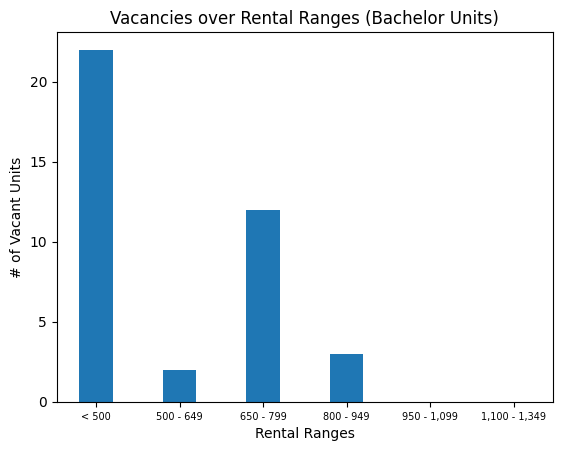

In [71]:
# General stuffs
import matplotlib.pyplot as plt
import numpy as np

# 
ranges = table2b_2["Rental Range"]

bachelor_rents = ranges.copy()[:6]
bachelor_vacants = table2b_2["Bachelor Vacant"][:6].apply(lambda x: int(x)) # 

# create stacked bar chart out of total sampled
x_axis = np.arange(len(bachelor_rents))
plt.bar(x_axis, bachelor_vacants, 0.4)

plt.xticks(x_axis, bachelor_rents, fontsize=7)
plt.title("Vacancies over Rental Ranges (Bachelor Units)")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

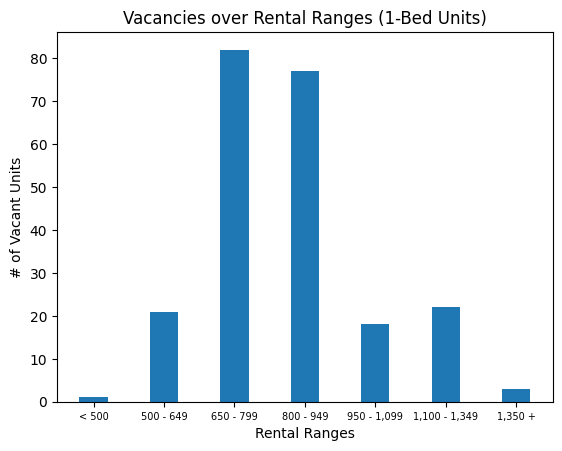

In [72]:
one_bed_vacants = table2b_2["1 - Bedroom Vacant"].apply(lambda x: int(x))

x_axis = np.arange(len(ranges))
plt.bar(x_axis, one_bed_vacants, 0.4)

plt.xticks(x_axis, ranges, fontsize=7)
plt.title("Vacancies over Rental Ranges (1-Bed Units)")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

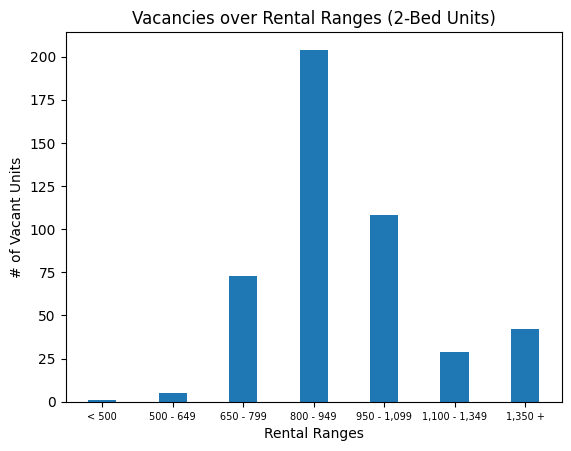

In [73]:
two_bed_vacants = table2b_2["2 - Bedroom Vacant"].apply(lambda x: int(x))

x_axis = np.arange(len(ranges))
plt.bar(x_axis, two_bed_vacants, 0.4)

plt.xticks(x_axis, ranges, fontsize=7)
plt.title("Vacancies over Rental Ranges (2-Bed Units)")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

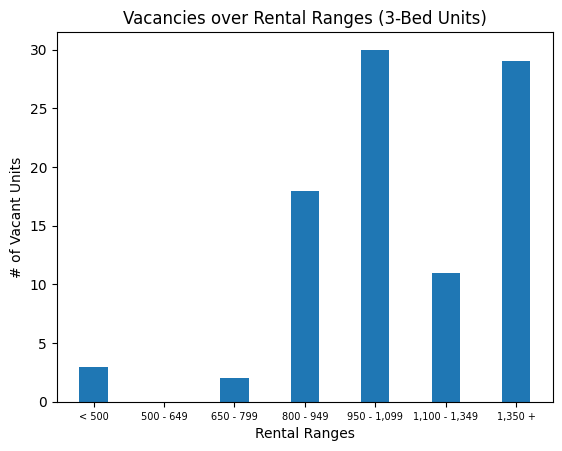

In [74]:
three_bed_vacants = table2b_2["3 - Bedroom Vacant"].apply(lambda x: int(x))

x_axis = np.arange(len(ranges))
plt.bar(x_axis, three_bed_vacants, 0.4)

plt.xticks(x_axis, ranges, fontsize=7)
plt.title("Vacancies over Rental Ranges (3-Bed Units)")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

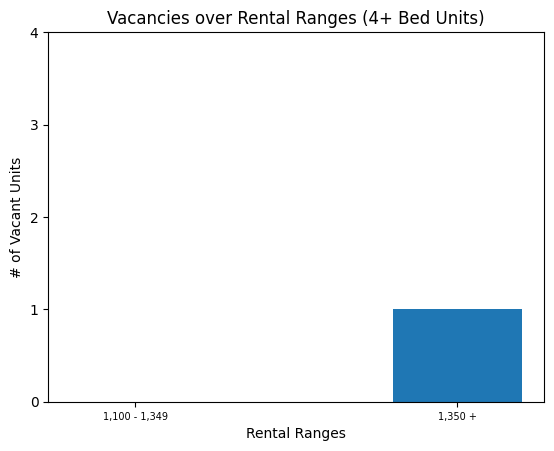

In [75]:
four_bed_vacants = table2b_2["4+ Bedroom Vacant"][5:].apply(lambda x: int(x))

x_axis = np.arange(len(ranges[5:]))
plt.ylim(0,4)
plt.bar(x_axis, four_bed_vacants, 0.4)

plt.xticks(x_axis, ranges[5:], fontsize=7)
plt.yticks([0,1,2,3,4])
plt.title("Vacancies over Rental Ranges (4+ Bed Units)")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

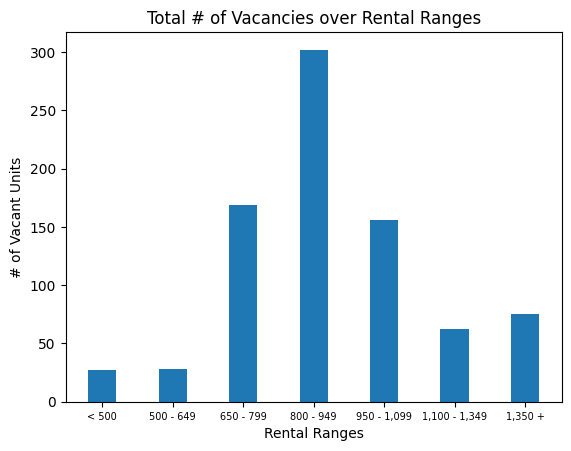

In [76]:
# Overall Vacancy vs Rental Range

# asdf
overall_table = table2b_2.copy()
overall_table.drop(["Bachelor % Vacancy","1 - Bedroom % Vacancy","2 - Bedroom % Vacancy","3 - Bedroom % Vacancy", "4+ Bedroom % Vacancy"], axis=1, inplace=True) #
overall_table.replace('-','0', inplace=True) #

# get total units for each type 
vacants = ["Bachelor Vacant", "1 - Bedroom Vacant", "2 - Bedroom Vacant", "3 - Bedroom Vacant", "4+ Bedroom Vacant"]   
overall_table[vacants] = overall_table[vacants].apply(lambda x: x.astype(int)) # convert 

vacants_totals = []
for i in range(7):
    vac = overall_table.loc[i, vacants].sum()
    vacants_totals.append(vac)

x_vals = np.arange(len(ranges))
plt.bar(x_vals, np.array(vacants_totals), 0.4)

plt.xticks(x_vals, ranges, fontsize=7)
plt.title("Total # of Vacancies over Rental Ranges")
plt.xlabel("Rental Ranges")
plt.ylabel("# of Vacant Units")
plt.show()

Potential Conclusions from these visuals:
- This one is pretty much just number of vacancies relative to the number of units over rental ranges
- Overall, for the most part pretty much mostly, the vacancies tend to be proportional to the number of units in that range

In [77]:
# plot line graph of Weighted Rent Changes for sampled towns --> for each, also display the vacancy rate between 2021 and 2022
# TODO divide population range into 3rds and create as buckets
# TODO pick 3 towns for each bucket as samples and generate SEPERATE weighted rent changes graph, and a line graph which takes the 3 towns together and plots the vacancy increase/decrease between 2021 and 2022

# this will do for now in place of the faceted graph, maybe we end up doing both actually heehee since faceted would be generalized to all?


In [128]:
pop_bins = [0, 3750, 7500, 11250, 15000]
population_sizes = pd.cut(table9_byAreaNames["2022"], bins=pop_bins, retbins=True)
population_sizes

(308        (0, 3750]
 330    (7500, 11250]
 296     (3750, 7500]
 26         (0, 3750]
 409        (0, 3750]
            ...      
 183     (3750, 7500]
 190     (3750, 7500]
 59         (0, 3750]
 131     (3750, 7500]
 300     (3750, 7500]
 Name: 2022, Length: 67, dtype: category
 Categories (4, interval[int64, right]): [(0, 3750] < (3750, 7500] < (7500, 11250] < (11250, 15000]],
 array([    0,  3750,  7500, 11250, 15000]))

In [132]:
small_towns = table9_byAreaNames[table9_byAreaNames["2022"] <= 3750]
small_towns

,Area Name,Type,2022
308,Athabasca,T,2827
26,Bassano,T,1255
409,Beaverlodge,T,2371
85,Black Diamond,T,2825
4,Bow Island,T,2129
137,Bowden,T,1297
202,Bruderheim,T,1392
145,Eckville,T,1079
260,Elk Point,T,1455
425,Fairview,T,2914


In [152]:
# Athabasca, Fort Macleod, Fox Creek
sample_smalltowns = ["Athabasca", "Fort Macleod", "Fox Creek"]
costs_smalltowns = table8[table8["Community"].isin(sample_smalltowns)]
vacancy_smalltowns = table6[table6["Community"].isin(sample_smalltowns)]

atha = costs_smalltowns[costs_smalltowns["Community"] == "Athabasca"]
atha_rents = atha[["2021 Weighted Rent", "2022 Weighted Rent"]]
atha

,Community,Unit Type,2021 Weighted Rent,2022 Weighted Rent
0,Athabasca,1 - Bedroom,840,852
1,Athabasca,2 - Bedroom,912,931
2,Athabasca,3 - Bedroom,1026,980
3,Athabasca,Bachelor,706,719


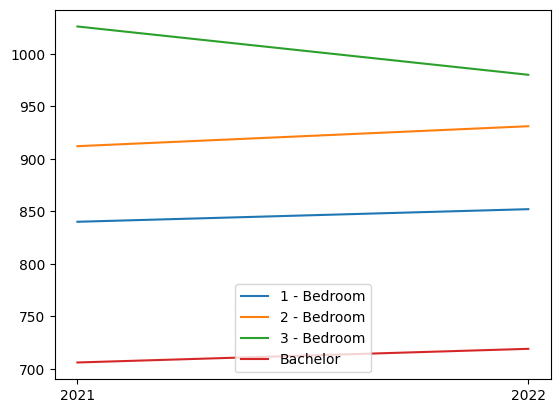

In [154]:
for i in range(len(atha.index)):
    plt.plot(["2021", "2022"], atha_rents.iloc[i], label=atha["Unit Type"].iloc[i])

plt.legend()
plt.show()

In [126]:
big_town = table9_byAreaNames[table9_byAreaNames["2022"] >= 7500]
big_town

,Area Name,Type,2022
330,Banff,T,9347
150,Blackfalds,T,11363
18,Coaldale,T,9179
68,Drumheller,T,8231
320,Edson,T,8399
81,High River,T,14996
319,Hinton,T,9933
138,Innisfail,T,8337
267,Lac La Biche,SM,8309
151,Lacombe,CY,14127
